In [ ]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from sklearn.preprocessing import MinMaxScaler
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense, LSTM
from sklearn.metrics import mean_absolute_error
import os

In [ ]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [ ]:
import time
start_time = time.time()

In [ ]:
# Path to the dataset folder
dataset_path = "/content/drive/MyDrive/Datasets/stocksData2022/"

# Read the specific stock file (Replace 'RELIANCE.csv' with the desired stock)
df = pd.read_csv(os.path.join(dataset_path, 'RELIANCE_with_indicators_.csv'))

In [ ]:
df[:1]

,date,open,high,low,close,volume,sma5,sma10,sma15,sma20,...,fastd,fastksr,fastdsr,ULTOSC,WILLR,ATR,Trange,TYPPRICE,HT_DCPERIOD,BETA
0,2015-02-02 14:30:00+05:30,452.4,452.9,451.85,451.9,689778,452.46,452.69,452.88,452.73,...,29.93266,0.0,16.344198,54.901832,-81.25,1.119881,1.05,452.216667,28.862505,0.417463


In [ ]:
# Prepare the dataset
scaler = MinMaxScaler(feature_range=(0, 1))
scaled_data = scaler.fit_transform(df['close'].values.reshape(-1, 1))

# Split the data into 80% for training and 20% for testing
train_data_len = int(len(scaled_data) * 0.8)
train_data = scaled_data[0:train_data_len, :]
test_data = scaled_data[train_data_len:, :]

In [ ]:
# Create the training dataset
x_train = []
y_train = []
for i in range(60, train_data_len):
    x_train.append(train_data[i-60:i, 0])
    y_train.append(train_data[i, 0])

# Convert lists to numpy arrays
x_train, y_train = np.array(x_train), np.array(y_train)

# Reshape the data for LSTM input
x_train = np.reshape(x_train, (x_train.shape[0], x_train.shape[1], 1))


In [ ]:
# Build the LSTM model
model = Sequential()
model.add(LSTM(50, return_sequences=True, input_shape=(x_train.shape[1], 1)))
model.add(LSTM(50, return_sequences=False))
model.add(Dense(25))
model.add(Dense(1))

# Compile and train the model
model.compile(optimizer='adam', loss='mean_squared_error')
model.fit(x_train, y_train, batch_size=1, epochs=1)


104218/104218 [==============================] - 3336s 32ms/step - loss: 4.5429e-05


In [ ]:
# Create the test dataset
x_test = []
y_test = df['close'][train_data_len:].values

for i in range(60, len(test_data)):
    x_test.append(test_data[i-60:i, 0])

# Convert lists to numpy arrays
x_test = np.array(x_test)

# Reshape the data for LSTM input
x_test = np.reshape(x_test, (x_test.shape[0], x_test.shape[1], 1))

# Make predictions and inverse transform the values
predictions = model.predict(x_test)
predictions = scaler.inverse_transform(predictions)




813/813 [==============================] - 16s 19ms/step


Evaluation Metric: We are using Mean Absolute Error (MAE) as the evaluation metric for comparing the predicted stock prices with the actual stock prices. This is a suitable choice because it provides an easy-to-interpret measure of the average error between the predicted and actual values.
We also calculated Mean Squared Error (MSE), Root Mean Squared Error (RMSE), and Mean Absolute Percentage Error (MAPE):



In [ ]:

from sklearn.metrics import mean_squared_error, mean_absolute_error
import numpy as np

# Calculate the Mean Absolute Error
min_length = min(len(predictions), len(y_test))

predictions_trimmed = predictions[:min_length]
y_test_trimmed = y_test[:min_length]

predictions_reshaped = predictions_trimmed.reshape(-1)

mae = mean_absolute_error(predictions_reshaped, y_test_trimmed)
print(f"Mean Absolute Error: {mae}")

# Calculate Mean Squared Error (MSE)
mse = mean_squared_error(y_test_trimmed, predictions_reshaped)
print(f"Mean Squared Error: {mse}")

# Calculate Root Mean Squared Error (RMSE)
rmse = np.sqrt(mse)
print(f"Root Mean Squared Error: {rmse}")

# Calculate Mean Absolute Percentage Error (MAPE)
mape = np.mean(np.abs((y_test_trimmed - predictions_reshaped) / y_test_trimmed)) * 100
print(f"Mean Absolute Percentage Error: {mape}%")


Mean Absolute Error: 23.547528123573265
Mean Squared Error: 992.7692243399304
Root Mean Squared Error: 31.50824057829841
Mean Absolute Percentage Error: 1.070911417293955%


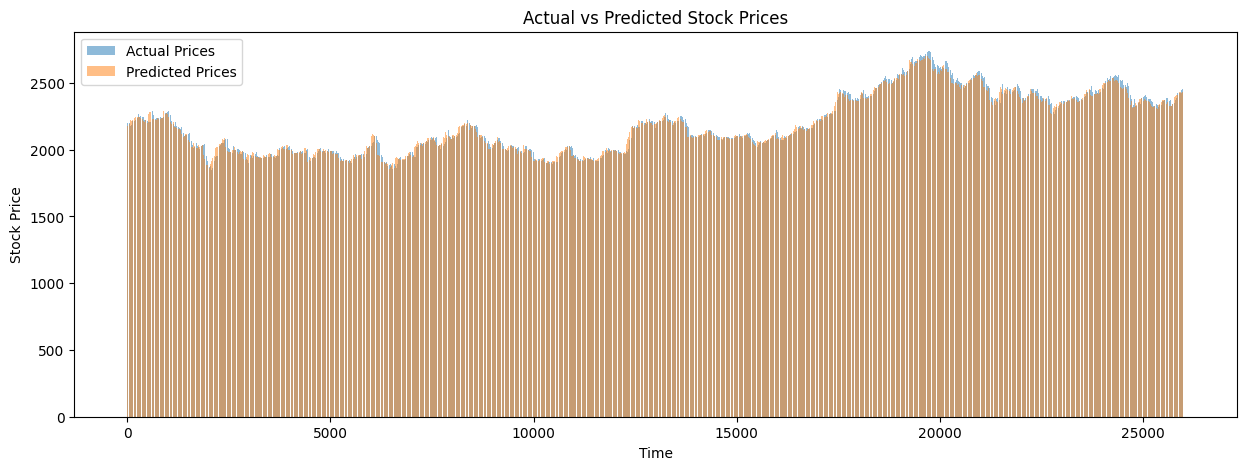

In [ ]:
# Plot the actual and predicted stock prices
index = range(min_length)

plt.figure(figsize=(15, 5))
plt.bar(index, y_test_trimmed, label='Actual Prices', alpha=0.5)
plt.bar(index, predictions_trimmed.reshape(-1), label='Predicted Prices', alpha=0.5)
plt.xlabel('Time')
plt.ylabel('Stock Price')
plt.legend(loc='upper left')
plt.title('Actual vs Predicted Stock Prices')
plt.show()

Dataset Size: Our dataset size can be found using the len(df) command. We can report the size of the dataset as well as the sizes of the training and testing sets. In our code, we have used an 80-20 split for training and testing data.

In [ ]:
total_data_size = len(df)
train_data_size = train_data_len
test_data_size = len(df) - train_data_len
print("Total data size: ", total_data_size)
print("Train data size: ", train_data_size)
print("Test data size: ", test_data_size)

Total data size:  130348
Train data size:  104278
Test data size:  26070


In [ ]:
# Get the dates corresponding to the test data
dates_test = df['date'].iloc[-min_length:]

# Create a DataFrame with actual and predicted prices
results_df = pd.DataFrame({'Date': dates_test, 'Actual Prices': y_test_trimmed, 'Predicted Prices': predictions_trimmed.reshape(-1)})
# results_df.set_index('Date', inplace=True)



In [ ]:
# Display the DataFrame
print(results_df["Date"])

104338    2020-09-25 10:00:00+05:30
104339    2020-09-25 10:05:00+05:30
104340    2020-09-25 10:10:00+05:30
104341    2020-09-25 10:15:00+05:30
104342    2020-09-25 10:20:00+05:30
                    ...            
130343    2022-02-18 15:05:00+05:30
130344    2022-02-18 15:10:00+05:30
130345    2022-02-18 15:15:00+05:30
130346    2022-02-18 15:20:00+05:30
130347    2022-02-18 15:25:00+05:30
Name: Date, Length: 26010, dtype: object


In [ ]:
end_time = time.time()
time_taken = end_time - start_time  # Make sure you subtract the start_time from end_time to get the elapsed time
time_taken_hours = time_taken / 3600
results_df["Time Taken for execution in hours"] = time_taken_hours
print("Time taken:", time_taken_hours, "hours")

Time taken: 1.362230388853285 hours


In [ ]:
!pip install xlsxwriter


Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/


In [ ]:
# create an Excel writer object
writer = pd.ExcelWriter('base_model_Reliance_stock_prediction_results.xlsx', engine='xlsxwriter')
results_df.to_excel(writer, index=False, sheet_name="results")
writer.save()

<ipython-input-79-32bbeaa7f079>:4: FutureWarning: save is not part of the public API, usage can give unexpected results and will be removed in a future version
  writer.save()


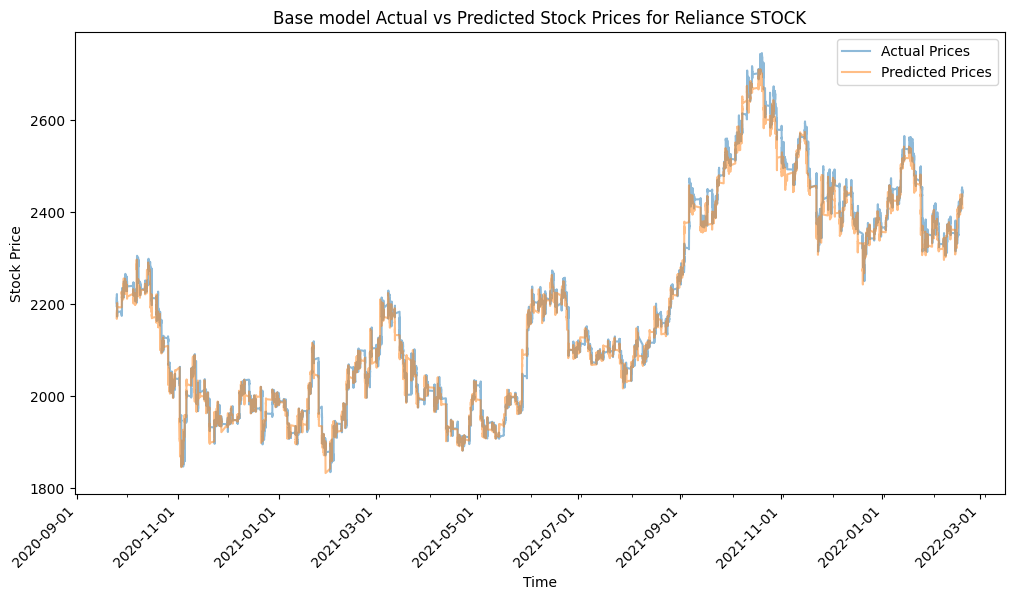

In [ ]:
import matplotlib.pyplot as plt
import matplotlib.dates as mdates
import matplotlib.ticker as ticker
import pandas as pd

# Convert the 'Date' column to datetime objects
results_df['Date'] = pd.to_datetime(results_df['Date'])

fig, ax = plt.subplots(figsize=(12, 6))

# Plot the actual prices
ax.plot(results_df['Date'], results_df['Actual Prices'], label='Actual Prices', alpha=0.5)

# Plot the predicted prices
ax.plot(results_df['Date'], results_df['Predicted Prices'], label='Predicted Prices', alpha=0.5)

# Format x-axis
ax.xaxis.set_major_locator(mdates.AutoDateLocator())
ax.xaxis.set_major_formatter(mdates.DateFormatter('%Y-%m-%d'))
ax.xaxis.set_minor_locator(ticker.AutoMinorLocator(2))  # Adjust the value '2' to control the number of minor ticks
plt.xticks(rotation=45, ha='right')

# Set the labels and title
ax.set_xlabel('Time')
ax.set_ylabel('Stock Price')
ax.set_title('Base model Actual vs Predicted Stock Prices for Reliance STOCK')
ax.legend()

plt.show()
